# Kaggle : Titanic competition

We'll be trying to solve a classification problem using Python. The data is from a Kaggle competition.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#!pip install xgboost
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Train Data

In [2]:
train = pd.read_csv('Datasets/train.csv')
display(train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


![title](Images/data_dictionnary.png)

# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing data

We can use seaborn to create a simple heatmap to see where we are missing data!

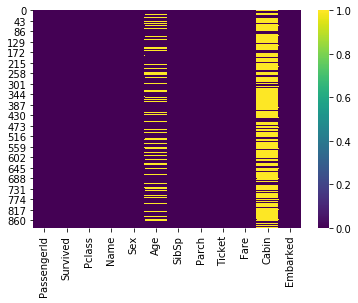

In [3]:
sns.heatmap(train.isnull(), cmap='viridis')
plt.show()

In [4]:
display(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

## Data Visualization

### Discrete Variables

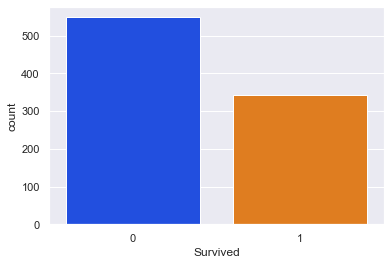

0    549
1    342
Name: Survived, dtype: int64


In [7]:
sns.set(style='darkgrid')
sns.countplot(x='Survived', data = train, 
              palette='bright')
plt.show()

print(train.Survived.value_counts())

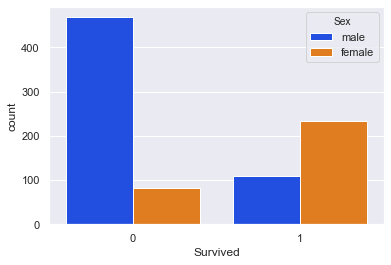

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64


In [6]:
sns.countplot(x='Survived', hue='Sex', data=train,
             palette='bright')
plt.show()

print(train.groupby('Sex').Survived.value_counts())

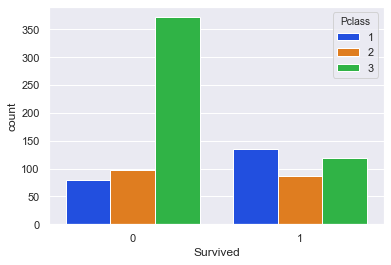

In [7]:
sns.countplot(x='Survived', hue='Pclass', 
              data = train, palette = 'bright')
plt.show()

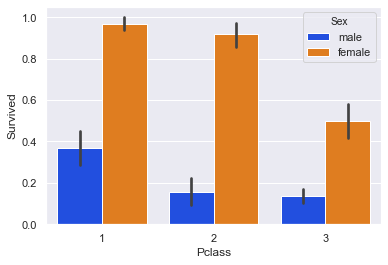

In [8]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', 
            data=train, palette='bright')
plt.show()

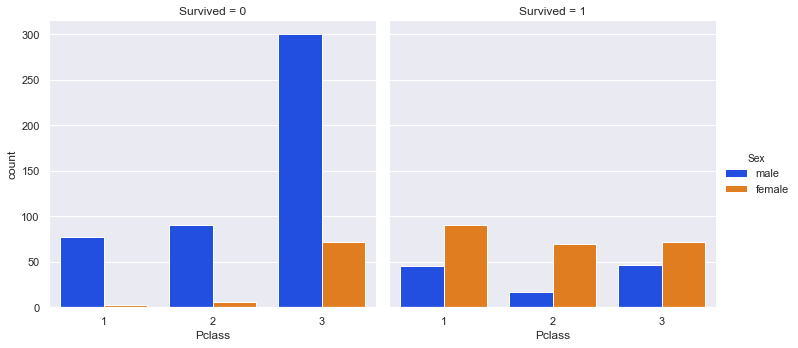

In [9]:
sns.catplot(x="Pclass", hue="Sex", col="Survived",
            data=train, kind="count", palette='bright')
plt.show()

### Continuous Variables

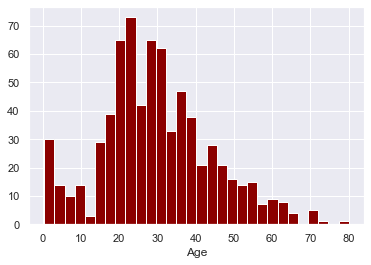

In [10]:
plt.hist(train.Age.dropna(), bins=30, 
         color='darkred')
plt.xlabel('Age')
plt.show()

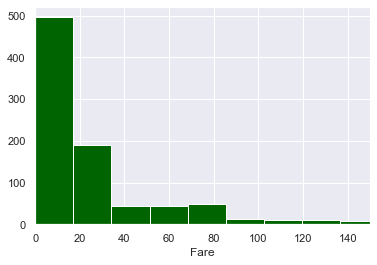

In [11]:
plt.hist(train.Fare, color='darkgreen', bins=30)
plt.xlim([0,150])
plt.xlabel('Fare')
plt.show()

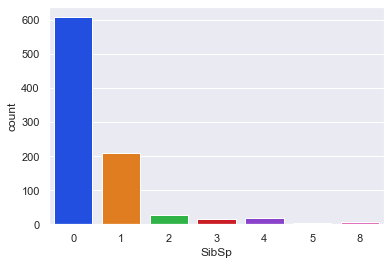

In [12]:
sns.countplot(x='SibSp', data=train, palette='bright')
plt.show()

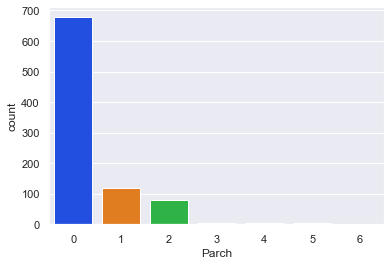

In [13]:
sns.countplot(x='Parch', data=train, 
              palette='bright')
plt.show()

### Correlation Matrix

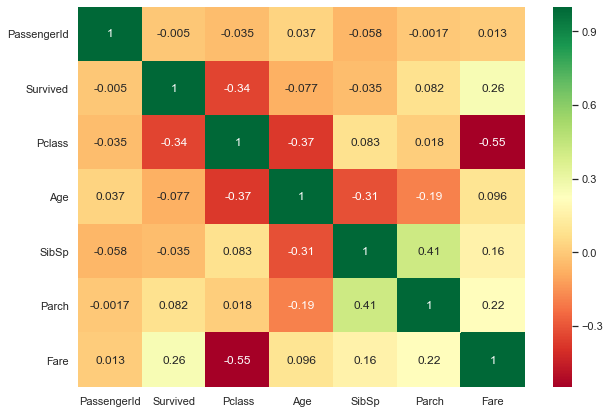

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn')
plt.show()

## Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

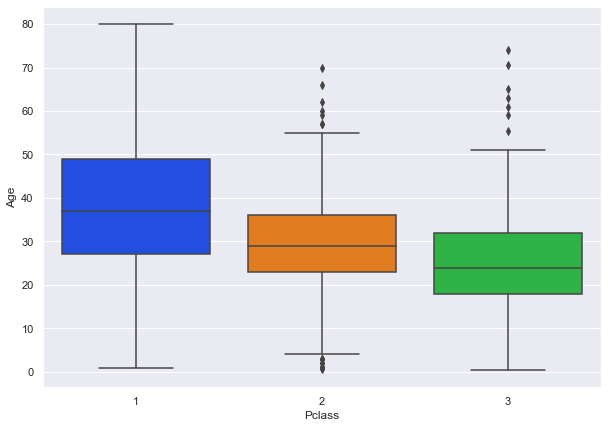

In [15]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=train, 
            palette='bright')
plt.show()

In [16]:
train.groupby('Pclass').Age.mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [5]:
mapping = {1:38, 2:30, 3:25}
train['Age'] = train['Age'].fillna(train['Pclass'].map(mapping))

Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [6]:
train.drop('Cabin', axis=1, inplace=True)
train.dropna(inplace=True)
display(train.head())
display(train.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


(889, 11)

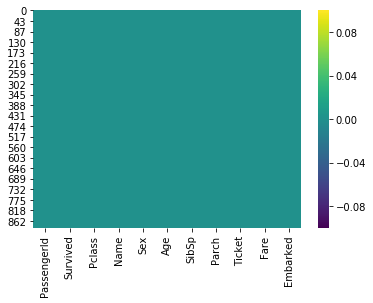

In [7]:
sns.heatmap(train.isnull(), cmap='viridis')
plt.show()

Great job! There is no more missing values in our train data 👏🏼

In [8]:
# Convert age into a categorical variables using the quartiles
display(train.Age.describe())

count    889.000000
mean      29.218414
std       13.178017
min        0.420000
25%       22.000000
50%       26.000000
75%       36.500000
max       80.000000
Name: Age, dtype: float64

In [9]:
def categorical_age(x):
    if 0 < x <= 22:
        return 0
    elif 22 < x <= 26:
        return 1
    elif 26 < x <= 36.5:
        return 2
    else:
        return 3

train['categorical_age'] = train['Age'].apply(categorical_age)

In [12]:
# Convert age into a categorical variables using the quartiles
display(train.Fare.describe())

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [11]:
def categorical_fare(x):
    if 0 < x <= 7.9:
        return 0
    elif 7.9 < x <= 14.5:
        return 1
    elif 14.5 < x <= 31:
        return 2
    else:
        return 3

train['categorical_fare'] = train['Fare'].apply(categorical_fare)

In [13]:
display(train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,categorical_age,categorical_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,2,1


## Converting Categorical Features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 13 columns):
PassengerId         889 non-null int64
Survived            889 non-null int64
Pclass              889 non-null int64
Name                889 non-null object
Sex                 889 non-null object
Age                 889 non-null float64
SibSp               889 non-null int64
Parch               889 non-null int64
Ticket              889 non-null object
Fare                889 non-null float64
Embarked            889 non-null object
categorical_age     889 non-null int64
categorical_fare    889 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 97.2+ KB


In [21]:
#categorical_features = ['Pclass', 'Sex', 'Embarked']
#train[categorical_features] = train[categorical_features].apply(lambda x: x.astype('category'))
#train.info()

In [15]:
train = pd.get_dummies(data=train, columns=['Sex', 'Embarked', 'Pclass', 'categorical_age', 'categorical_fare'], drop_first=True)

In [16]:
train.drop(['Name', 'Ticket', 'Age', 'Fare', 'PassengerId'], axis=1, inplace=True)

In [17]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
Survived              889 non-null int64
SibSp                 889 non-null int64
Parch                 889 non-null int64
Sex_male              889 non-null uint8
Embarked_Q            889 non-null uint8
Embarked_S            889 non-null uint8
Pclass_2              889 non-null uint8
Pclass_3              889 non-null uint8
categorical_age_1     889 non-null uint8
categorical_age_2     889 non-null uint8
categorical_age_3     889 non-null uint8
categorical_fare_1    889 non-null uint8
categorical_fare_2    889 non-null uint8
categorical_fare_3    889 non-null uint8
dtypes: int64(3), uint8(11)
memory usage: 37.3 KB


None

In [18]:
display(train.head())

,Survived,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,categorical_age_1,categorical_age_2,categorical_age_3,categorical_fare_1,categorical_fare_2,categorical_fare_3
0,0,1,0,1,0,1,0,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,1,1,0,0,1,0,0
3,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,1,0,1,0,1,0,1,0,0


**Great! Our data is ready to build Supervised Learning Estimators**

# Supervised Learning Estimators

## Training And Test Data

In [26]:
y = train.Survived.values
X = train.drop('Survived', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression Model

In [27]:
lr = LogisticRegression(solver='lbfgs', max_iter=500, C=0.1, random_state=42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Test accuracy: %.3f' % lr.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
print(f'\n{classification_report(y_test, y_pred)}')

Test accuracy: 0.828
Test Mean squared error: 0.172

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       167
           1       0.79      0.73      0.76       100

    accuracy                           0.83       267
   macro avg       0.82      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267



In [33]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(solver='liblinear', random_state=42))]
         
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'logreg__C':np.logspace(-5, 8, 15),
             'logreg__penalty': ['l1', 'l2']}

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
gm_cv.fit(X_train, y_train)

y_pred = gm_cv.predict(X_test)

print('Test accuracy: %.3f' % gm_cv.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))

Test accuracy: 0.813
Test Mean squared error: 0.187


## Decision Tree Classification

In [50]:
dtc = DecisionTreeClassifier(max_features=7, max_depth=3, min_samples_split=2, random_state=42)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

print('Test accuracy: %.3f' % dtc.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
print(f'\n{classification_report(y_test, y_pred)}')

Test accuracy: 0.805
Test Mean squared error: 0.195

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       167
           1       0.77      0.69      0.73       100

    accuracy                           0.81       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267



## Random Forest Classifier

In [50]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=8, max_features=7, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Test accuracy: %.3f' % rfc.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
print(f'\n{classification_report(y_test, y_pred)}')

Test accuracy: 0.801
Test Mean squared error: 0.199

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       167
           1       0.76      0.68      0.72       100

    accuracy                           0.80       267
   macro avg       0.79      0.78      0.78       267
weighted avg       0.80      0.80      0.80       267



## Support Vector Classifier

In [53]:
svc = SVC(gamma = 0.5, C = 100, random_state=42)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print('Test accuracy: %.3f' % svc.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
print(f'\n{classification_report(y_test, y_pred)}')

Test accuracy: 0.794
Test Mean squared error: 0.206

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       167
           1       0.74      0.69      0.72       100

    accuracy                           0.79       267
   macro avg       0.78      0.77      0.78       267
weighted avg       0.79      0.79      0.79       267



## Gradient Boosting Classifier

In [58]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

print(gbc.score(X_test, y_test))

print(classification_report(y_test, y_pred))

0.8202247191011236
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       167
           1       0.78      0.72      0.75       100

    accuracy                           0.82       267
   macro avg       0.81      0.80      0.80       267
weighted avg       0.82      0.82      0.82       267



In [52]:
steps = [('sc', StandardScaler()),
    ('gbc', GradientBoostingClassifier(random_state=42))]

pipeline = Pipeline(steps)

params = {'gbc__n_estimators': [50, 100, 200, 500],
         'gbc__max_depth':[2, 5, 10, 15]}

grid = GridSearchCV(pipeline, param_grid=params, cv=5)

grid.fit(X_train, y_train)

print(f'The accuracy score in training is : {grid.score(X_train, y_train)}')

y_pred = grid.predict(X_test)

print(f'The accuracy score in test is : {grid.score(X_test, y_test)}')

print(classification_report(y_test, y_pred))

The accuracy score in training is : 0.9019292604501608
The accuracy score in test is : 0.8014981273408239
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       167
           1       0.77      0.67      0.72       100

    accuracy                           0.80       267
   macro avg       0.79      0.78      0.78       267
weighted avg       0.80      0.80      0.80       267



## XGB Classifier

In [66]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('The accuracy score in training is: %.3f' % xgb_model.score(X_train, y_train))
print('The accuracy score in test is: %.3f' % xgb_model.score(X_test, y_test))
print('Test Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
print(f'\n{classification_report(y_test, y_pred)}')

The accuracy score in training is: 0.859
The accuracy score in test is: 0.813
Test Mean squared error: 0.187

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       167
           1       0.80      0.67      0.73       100

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.81       267



## Neural Network with Keras

In [33]:
# Define the scaler 
#scaler = StandardScaler().fit(X)

# Scale the train set
#X = scaler.transform(X)

In [78]:
# Save the number of columns in predictors: n_cols
n_cols = X.shape[1]

# Convert the target to categorical: target
target = to_categorical(y)

# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))

# Add the second layer
model.add(Dense(50, activation='relu'))

# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
hist = model.fit(X, target, epochs=30, validation_split=0.2,  callbacks=[early_stopping_monitor])

Train on 711 samples, validate on 178 samples
Epoch 1/30
711/711 [==============================] - 0s 195us/step - loss: 0.2171 - accuracy: 0.6723 - val_loss: 0.1865 - val_accuracy: 0.7360
Epoch 2/30
711/711 [==============================] - 0s 46us/step - loss: 0.1899 - accuracy: 0.7159 - val_loss: 0.1644 - val_accuracy: 0.7865
Epoch 3/30
711/711 [==============================] - 0s 47us/step - loss: 0.1706 - accuracy: 0.7848 - val_loss: 0.1492 - val_accuracy: 0.8034
Epoch 4/30
711/711 [==============================] - 0s 44us/step - loss: 0.1562 - accuracy: 0.8003 - val_loss: 0.1389 - val_accuracy: 0.8315
Epoch 5/30
711/711 [==============================] - 0s 43us/step - loss: 0.1478 - accuracy: 0.8129 - val_loss: 0.1356 - val_accuracy: 0.8258
Epoch 6/30
711/711 [==============================] - 0s 41us/step - loss: 0.1416 - accuracy: 0.8242 - val_loss: 0.1313 - val_accuracy: 0.8315
Epoch 7/30
711/711 [==============================] - 0s 42us/step - loss: 0.1376 - accuracy: 0

In [79]:
print('Train Accuracy: %.4f' % hist.history['accuracy'][-1])
print('Test Accuracy: %.4f' % hist.history['val_accuracy'][-1])

Train Accuracy: 0.8481
Test Accuracy: 0.8371


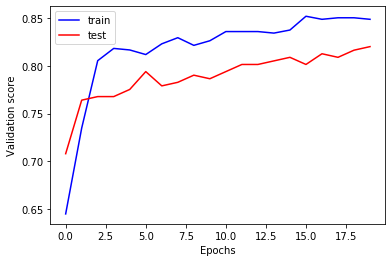

In [91]:
# Create the plot
plt.plot(hist.history['accuracy'], 'b', hist.history['val_accuracy'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['train', 'test'])
plt.show()

# Test Data 

In [28]:
test = pd.read_csv('Datasets/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Cleaning

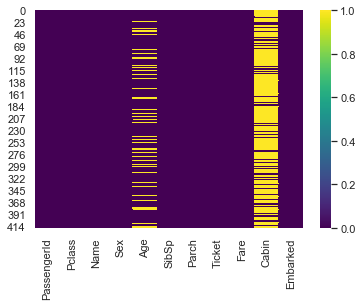

In [161]:
sns.heatmap(test.isnull(), cmap='viridis')
plt.show()

In [34]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [29]:
mapping = {1:38, 2:30, 3:25}
test['Age'] = test['Age'].fillna(test['Pclass'].map(mapping))

In [94]:
# Convert age into a categorical variables using the quartiles
display(test.Age.describe())

count    418.000000
mean      29.527512
std       12.851641
min        0.170000
25%       23.000000
50%       25.000000
75%       36.375000
max       76.000000
Name: Age, dtype: float64

In [30]:
def categorical_age(x):
    if 0 < x <= 23:
        return 0
    elif 23 < x <= 25:
        return 1
    elif 25 < x <= 36.4:
        return 2
    else:
        return 3

test['categorical_age'] = test['Age'].apply(categorical_age)

In [31]:
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [98]:
# Convert age into a categorical variables using the quartiles
display(test.Fare.describe())

count    418.000000
mean      35.627188
std       55.840500
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [32]:
def categorical_fare(x):
    if 0 < x <= 7.9:
        return 0
    elif 7.9 < x <= 14.5:
        return 1
    elif 14.5 < x <= 31.5:
        return 2
    else:
        return 3

test['categorical_fare'] = test['Fare'].apply(categorical_fare)

In [33]:
display(test.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,categorical_age,categorical_fare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,3,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,3,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,1


In [34]:
test = pd.get_dummies(data=test, columns=['Sex', 'Embarked', 'Pclass', 'categorical_age', 'categorical_fare'], drop_first=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
PassengerId           418 non-null int64
Name                  418 non-null object
Age                   418 non-null float64
SibSp                 418 non-null int64
Parch                 418 non-null int64
Ticket                418 non-null object
Fare                  418 non-null float64
Cabin                 91 non-null object
Sex_male              418 non-null uint8
Embarked_Q            418 non-null uint8
Embarked_S            418 non-null uint8
Pclass_2              418 non-null uint8
Pclass_3              418 non-null uint8
categorical_age_1     418 non-null uint8
categorical_age_2     418 non-null uint8
categorical_age_3     418 non-null uint8
categorical_fare_1    418 non-null uint8
categorical_fare_2    418 non-null uint8
categorical_fare_3    418 non-null uint8
dtypes: float64(2), int64(3), object(3), uint8(11)
memory usage: 30.7+ KB


In [35]:
PassengerId = test['PassengerId']
display(PassengerId.head())

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [36]:
test.drop(['Name', 'Ticket', 'Cabin', 'Age', 'Fare', 'PassengerId'], axis=1, inplace=True)

In [37]:
display(test.head())

,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,categorical_age_1,categorical_age_2,categorical_age_3,categorical_fare_1,categorical_fare_2,categorical_fare_3
0,0,0,1,1,0,0,1,0,1,0,0,0,0
1,1,0,0,0,1,0,1,0,0,1,0,0,0
2,0,0,1,1,0,1,0,0,0,1,1,0,0
3,0,0,1,0,1,0,1,0,1,0,1,0,0
4,1,1,0,0,1,0,1,0,0,0,1,0,0


## Prediction using the best model

In [111]:
# Neural Networks
X_new = np.array(test)

# Scale the test set
# X_new = scaler.transform(X_new)

test_prediction = model.predict_classes(X_new)

In [38]:
X_new = np.array(test)

test_prediction = lr.predict(X_new)

In [39]:
submission = pd.DataFrame(test_prediction, columns=['Survived'])

In [40]:
submission = pd.concat([PassengerId, submission], axis=1)

In [41]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [42]:
submission.to_csv('submission.csv', index=False)

In [44]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv('submission.csv')
display(submissions_check.head())

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
